# Objectives


* To explore an existing dataset
> This week, we'll use a subset of the UK Met dataset. You can read more about the UK Met dataset here: https://rmets.onlinelibrary.wiley.com/doi/10.1002/gdj3.78. We will use the 60km-resolution data for 2010 to 2022.

* To apply support vector machine (SVM) and logistic regression algorithms from Week 3 lecture to automatic detection of the number of days of ground frost and snow based on other weather variables.

# Section 1 - Explore the UK Met (60km, 2010-2022) dataset

See the dataset on the Week 3 page for the module, on Canvas (see 'Week 3 Lab Dataset' on the page). The file is named c*urated_data_1month_2010-2022_nonans.csv*.
* What does each variable in the dataset represent?
  * Coordinates, Month, year, days of ground frost, relative humidity, sea level pressure, vapour pressure, total rainfall, wind speed, days of snow, sunshine, air temperature.
* What is the distribution of the number of days of ground frost in the dataset? What of for the number of days of snow?
  * ground frost:
    * Avg	7.94
    * Median	6.87
    * Stdev	6.95
    * Min	0.00077
    * Max	28.02
  * Snow:
    * Avg	0.896
    * Median	0.013
    * Stdev	2.245
    * Min	0.000
    * Max	23.949
* What does this tell you about the data?
  * High values are under-represented 
* What else can you tell about the data?
  * minimunm values of ground frost and snow are almost zero.


# Section 2 - Load the dataset





1. You need to first download the data before you can get started. Download from the Week 3 page for the module, on Canvas (see 'Week 3 Lab Dataset' on the page). The file you download will be named *curated_data_1month_2010-2022_nonans.csv*.

2. Then, use the file menu in Google Colab to upload the file to your Colab directory. Once upload is complete, you should be able to see the file on the listed contents of your Colab directory.

3. You can now run the code in the cell below to load the data.

In [2]:
import csv
import numpy


!ls  /content

data_file_full_path = "/Users/suli/Documents/source/repo/MachineLearning/Week 3/curated_data_1month_2010-2022_nonans.csv"

data_as_list = []

# load the dataset
with open(data_file_full_path) as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')

    row_count = 0
    for row in csv_reader:

      if row_count > 0:
        data_as_list.append([float(val) for val in row])
      row_count += 1
data = numpy.array(data_as_list)

# check its shape
print("\n The dataset has shape: "+str(data.shape))


# get features and labels from the data
# based on the objectives (see the Objectives section)
feat_col = [5, 6, 7, 8, 9, 10, 11]
ground_frost_col = 4
snow_col = 12

feats = data[:, feat_col]
ground_frost_label = data[:, ground_frost_col]
snow_label = data[:, snow_col]


# take a peek
print("\n A peek at the dataset features: \n"+str(feats))
print("\n A peek at the ground frost labels: \n"+str(ground_frost_label))
print("\n A peek at the snow labels: \n"+str(snow_label))


ls: /content: No such file or directory

 The dataset has shape: (10296, 13)

 A peek at the dataset features: 
[[8.93698275e+01 1.02266536e+03 6.45115642e+01 ... 6.45810733e+00
  6.72744772e+00 6.97199793e-01]
 [8.94462109e+01 1.02270800e+03 5.74868117e+01 ... 5.88191052e+00
  6.23064828e+00 1.62952568e+00]
 [8.93435447e+01 1.02243684e+03 6.82935149e+01 ... 4.62830127e+00
  6.29080656e+00 1.17293773e+00]
 ...
 [8.78370293e+01 1.00645706e+03 1.38800195e+01 ... 4.96064026e+00
  1.85626301e+00 7.99709543e+00]
 [8.88116315e+01 1.00662248e+03 2.05853162e+01 ... 4.93635497e+00
  7.75835354e-01 8.46815900e+00]
 [8.27601516e+01 1.00593830e+03 1.05309193e+01 ... 8.38081942e+00
  3.54509758e+00 6.35990610e+00]]

 A peek at the ground frost labels: 
[ 9.84928987 10.85267889 12.97189949 ... 21.7275541  23.77582838
 17.35386163]

 A peek at the snow labels: 
[112.2352382  116.3547495   57.53778808 ... 177.2424627  135.4028786
 140.831213  ]


# Section 3 - Split into training, validation, and test sets

In [3]:
from sklearn.model_selection import train_test_split

all_ids = numpy.arange(0, feats.shape[0])

random_seed = 1

# First randomly split the data into 70:30 to get the training set
train_set_ids, rem_set_ids = train_test_split(all_ids, test_size=0.3, train_size=0.7,
                                 random_state=random_seed, shuffle=True)


# Then further split the remaining data 50:50 into validation and test sets
val_set_ids, test_set_ids = train_test_split(rem_set_ids, test_size=0.5, train_size=0.5,
                                 random_state=random_seed, shuffle=True)


train_data = feats[train_set_ids, :]
train_ground_frost_labels = ground_frost_label[train_set_ids]
train_snow_labels = snow_label[train_set_ids]

val_data = feats[val_set_ids, :]
val_ground_frost_labels = ground_frost_label[val_set_ids]
val_snow_labels = snow_label[val_set_ids]

test_data = feats[test_set_ids, :]
test_ground_frost_labels = ground_frost_label[test_set_ids]
test_snow_labels = snow_label[test_set_ids]

# Section 4 - Train and evaluate a SVM regression model (with hyperparameter optimization)

In [4]:

from sklearn.svm import LinearSVR
from sklearn.metrics import mean_squared_error
import sys

#--- Use the validation set to optimize the box constraint hyperparameter ---
#--- based on grid search method ---

# set the range of hyperparameters to search from
c_options = [0.1, 1.0, 10.0]
# initialize the optimal box constraint value
best_c = 0.1
# initialize the performance of the optimal box constraint value
best_c_perf = sys.float_info.max

# for each box constraint in the set of values to search
# training a SVM model and evaluate it
# if the performance obtained is better than the currrent 'best_c_perf'
# set the box constraint as the current optimal
for c in c_options:
  #print("\n for c="+str(c)+"...")
  model_SVM = LinearSVR(C=c, random_state=random_seed, loss='squared_epsilon_insensitive')
  model_SVM.fit(train_data, train_ground_frost_labels)
  val_pred_SVM = model_SVM.predict(val_data)
  val_mse_SVM = mean_squared_error(val_ground_frost_labels, val_pred_SVM)

  if val_mse_SVM < best_c_perf:
    best_c = c
    best_c_perf = val_mse_SVM

print('\n The optimal c for this data is: '+str(best_c))


# use the optimized box constraint to train the final model
model_SVM = LinearSVR(C=best_c, random_state=random_seed, loss='squared_epsilon_insensitive')
model_SVM.fit(train_data, train_ground_frost_labels)

# evaluate the trained model using the test set
test_pred_SVM = model_SVM.predict(test_data)
mse_SVM = mean_squared_error(test_ground_frost_labels, test_pred_SVM)
print('\n The test mean squared error (MSE) is: '+str(mse_SVM))




 The optimal c for this data is: 0.1

 The test mean squared error (MSE) is: 5.602921948234302


In LinearSVR, C is the regularization parameter (often referred to as the “box constraint”). It controls the trade-off between the model’s simplicity and its ability to fit the training data:

- Lower values of C: Impose stronger regularization. This encourages the model to keep the coefficients small, leading to a simpler model that might underfit the data.
- Higher values of C: Reduce the regularization strength. This allows the model to fit the training data more closely, which can improve performance on the training set but may risk overfitting.

# Section 5 - Train and evaluate with scaled features

* Read the StandardScaler documentation (https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html). Using the documentation above, compute scaled features from *feats* in Section 2 based on standard scaling.

* Train and evaluate the SVM model with the scaled features.

* What differences do you notice in the feature distribution and the results?


Before starting with the code, it's important to understand scaling using StandardScaler from SKLearn.

Simply, StandardScaler is a preprocessing tool from Scikit-learn that standardizes the data. It does this by computing the mean and standard deviation for each feature in the dataset (feats), and then uses these values to rescale the features. Specifically, for each feature it subtracts the mean and divides by the standard deviation. This transformation produces a dataset where each feature has a mean of 0 and a variance of 1.

Many machine learning models perform better when the input features are on a similar scale. For example, models that rely on distance calculations (like SVMs, KNN, etc.) benefit from scaling, as features with larger numeric ranges can unduly influence the model.

While similar in spirit to traditional linear regression, LinearSVR minimizes a loss that ignores errors (or residuals) smaller than a specified threshold (called the epsilon parameter). This is known as the “epsilon-insensitive” loss. The model also includes a hyperparameter C which controls the trade-off between having a flat regression function and minimizing the training error. In essence, LinearSVR tries to find a hyperplane that best fits the data while allowing for some errors within a margin (epsilon).


In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import sys
Scaler = StandardScaler()
Scaler.fit(feats)
scaled_feats = Scaler.transform(feats)
print("\n A peek at the scaled features: \n"+str(scaled_feats))

scaled_train_data = scaled_feats[train_set_ids, :]
scaled_val_data = scaled_feats[val_set_ids, :]
scaled_test_data = scaled_feats[test_set_ids, :]

# set the range of hyperparameters to search from
c_options = [0.1, 1.0, 10.0]
# initialize the optimal box constraint value
best_c = 0.1
# initialize the performance of the optimal box constraint value
best_c_perf = sys.float_info.max

# for each box constraint in the set of values to search
# training a SVM model and evaluate it
# if the performance obtained is better than the currrent 'best_c_perf'
# set the box constraint as the current optimal
for c in c_options:

  model_SVM = LinearSVR(C=c, random_state=random_seed, loss='squared_epsilon_insensitive')
  model_SVM.fit(scaled_train_data, train_ground_frost_labels)
  val_pred_SVM = model_SVM.predict(scaled_val_data)
  val_mse_SVM = mean_squared_error(val_ground_frost_labels, val_pred_SVM)

  if val_mse_SVM < best_c_perf:
    best_c = c
    best_c_perf = val_mse_SVM

print('\n The optimal c for the scaled data is: '+str(best_c))


# use the optimized box constraint to train the final model
model_SVM = LinearSVR(C=best_c, random_state=random_seed, loss='squared_epsilon_insensitive')
model_SVM.fit(scaled_train_data, train_ground_frost_labels)

# evaluate the trained model using the test set
test_pred_SVM = model_SVM.predict(scaled_test_data)
mse_SVM = mean_squared_error(test_ground_frost_labels, test_pred_SVM)
print('\n The test MSE is: '+str(mse_SVM))


 A peek at the scaled features: 
[[ 1.32716655  1.57084147 -0.88330353 ...  1.51819974 -0.59716362
  -0.08830932]
 [ 1.34196535  1.57808582 -0.99442844 ...  1.03005351 -0.70725389
   0.32720564]
 [ 1.32207443  1.53201409 -0.82347666 ... -0.03198748 -0.69392287
   0.1237155 ]
 ...
 [ 1.03019683 -1.18300764 -1.68424647 ...  0.24956567 -1.67661336
   3.16507655]
 [ 1.2190197  -1.15490117 -1.57817505 ...  0.2289915  -1.91603506
   3.37501812]
 [ 0.04658465 -1.27114612 -1.73722605 ...  3.1470957  -1.30236928
   2.4354211 ]]

 The optimal c for the scaled data is: 10.0

 The test MSE is: 4.651567722366653


- StandardScaler is a data preprocessing tool. It transforms your input features so that each feature has a standard scale (zero mean and unit variance).
- LinearSVR is a machine learning estimator. It learns a linear model from your (possibly scaled) data to predict continuous target values.
--
- StandardScaler performs a fixed mathematical transformation (scaling) based solely on the statistics (mean and standard deviation) of the data. It does not “learn” relationships between features and a target variable.
- LinearSVR “learns” by fitting a model to the data—it optimizes the parameters of a linear function to best predict the target variable based on the training examples.

# Section 6 - Train and evaluate a LR classification model

* Use the information from Section 1 to split the ground frost label values into 4 classes.
* Apply this to create classification labels for the labels in Section 2.
* Use the classification labels to train and evaluate a logistic regression model using the Scikit Learn library (https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).


Logistic regression is a statistical method used primarily for classification tasks. Despite its name, it isn’t used for regression (predicting continuous outcomes) but rather for predicting the probability of a categorical outcome. 

Classification: Logistic regression is used to classify data into two or more classes. In its simplest form (binary logistic regression), it predicts whether an instance belongs to one class or another (e.g., spam vs. not spam).

Probabilistic Output: It outputs a probability between 0 and 1. This probability can be converted into a class label by choosing a cutoff (commonly 0.5).

Linear Combination: The model starts by taking a linear combination of the input features. 

Logistic (Sigmoid) Function: Instead of using the linear combination directly, logistic regression passes this value through the logistic function (also known as the sigmoid function)

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from copy import deepcopy

# classify the ground frost labels into 4 classes

ground_frost_label_class = deepcopy(ground_frost_label)
numpy.place(ground_frost_label_class, ground_frost_label_class<=0.95, 0)
numpy.place(ground_frost_label_class, numpy.logical_and(ground_frost_label_class>0.95, ground_frost_label_class<=6.87), 1)
numpy.place(ground_frost_label_class, numpy.logical_and(ground_frost_label_class>6.87, ground_frost_label_class<=13.87), 2)
numpy.place(ground_frost_label_class, ground_frost_label_class>13.87, 3)

print("\n A peek at the classification ground frost labels: \n"+str(ground_frost_label_class))


train_ground_frost_labels_class = ground_frost_label_class[train_set_ids]
val_ground_frost_labels_class = ground_frost_label_class[val_set_ids]
test_ground_frost_labels_class = ground_frost_label_class[test_set_ids]



model_LR = LogisticRegression(penalty='l2', random_state=random_seed)
model_LR.fit(scaled_train_data, train_ground_frost_labels_class)


test_pred_LR = model_LR.predict(scaled_test_data)
acc_LR = accuracy_score(test_ground_frost_labels_class, test_pred_LR)
print('\n The test accuracy is: '+str(acc_LR))





 A peek at the classification ground frost labels: 
[2. 2. 2. ... 3. 3. 3.]

 The test accuracy is: 0.7987055016181229


# Section 7 - Evaluate using other classification metrics


 The F1 scores for each of the classes are: [0.87878788 0.73809524 0.72887768 0.84913218]

 The average F1 score is: 0.7987232432038622



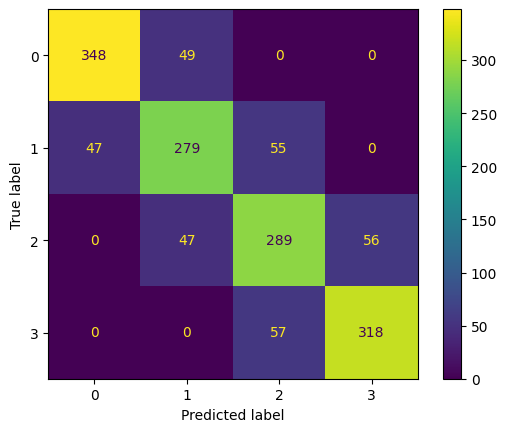

In [9]:
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# F1 score similar to accuracy in that it ranges between 0 and 1
# We will look at this metric in Weeks 5-6
avg_f1_score_LR = f1_score(test_ground_frost_labels_class, test_pred_LR, average='macro')
f1_scores_LR = f1_score(test_ground_frost_labels_class, test_pred_LR, average=None)
print('\n The F1 scores for each of the classes are: '+str(f1_scores_LR))
print('\n The average F1 score is: '+str(avg_f1_score_LR))
print()

# Confusion shows the misclassification
# We will look at this metric in Weeks 5-6
confusion_matrix_SVM = confusion_matrix(test_ground_frost_labels_class, test_pred_LR)
disp = ConfusionMatrixDisplay(confusion_matrix_SVM)
disp.plot()
plt.show()
